## **Introdução de LangChain/LangGraph**

*Framework* para a criação de agentes inteligentes.

Instalação das bibliotecas necessárias.

In [ ]:
# !pip install -U -q langgraph langchain langchain-google-genai langchain_community

*Imports* e *setup* de chaves de API.

- Google Gemini API Key: https://aistudio.google.com/app/apikey?hl=pt-br

In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

### **O grafo mais simples**

Construindo um simples grafo com 4 nós e uma aresta condicional

##### **State**

A primeira coisa que se deve definir quando criando uma grafo é o *State* do grafo.

O esquema do *state* serve como um esquema de *input* para todos os nós e arestas no grafo.

O exemplo a seguir usa uma simples estrutura de dicionário com apenas um `graph_state` do tipo str.

In [2]:
from typing import TypedDict

# Dicionário com uma única chave "graph_state"
class State(TypedDict):
    graph_state: str

In [3]:
state = State(graph_state="Ola")
state

{'graph_state': 'Ola'}

##### **Nós**

De forma geral, nós são apenas funções em Python.

O primeiro argumento da função é o *state*, como mostrado abaixo.

Cada nó opera no *state*.

Por padrão, cada nó irá também sobrescrever o valor anterior do *state*.

In [4]:
# Nós
def node_1(state) -> str:
    print("--- Nó 1 ---")
    return {"graph_state": state["graph_state"] + " Eu estou"}


def node_2(state) -> str:
    print("--- Nó 2 ---")
    return {"graph_state": state["graph_state"] + " feliz!"}


def node_3(state) -> str:
    print("--- Nó 3 ---")
    return {"graph_state": state["graph_state"] + " triste!"}

##### **Arestas**

Arestas conectam nós.

- **Arestas normais** são usadas se você quiser sempre ir, por exemplo, do `node_1`para o `node_2`;
- **Arestas condicionais** são usadas quando você quiser uma rota opcional entre nós.

A aresta condicional é implementada como uma função que retorna o próximo nó a ser visitado baseando-se em algum lógica.

In [6]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    # O estado é frequentemente utilizado para decidir o próximo nó
    user_input = state['graph_state']

    # Aqui, um 50/50 irá decidir entre nós 2 e 3
    if random.random() < .5:
        # 50% das vezes irá retornar Nó 2
        return "node_2"
    # 50% das vezes irá retornar Nó 3
    return "node_3"

##### **Construção do Grafo**

O grafo é construído a partir dos nossos componentes.

O *__StateGraph__* é a principal classe de grafos no LangGraph.

Primeiro, se deve inicializar um *StateGraph* com a classe de `State` definida anteriormente.

Então, se deve adicionar os nós e arestas.

Se utiliza o nó `START` para indicar o início de nosso grafo. É um nó especial que envia a mensagem do usuário (*input*) para o grafo.

O nó `END` é o nó especial que representa o término do grafo.

Compilar o grafo executa algumas checagens básicas sobre a estrutura do seu grafo (sem nós órfãos, etc).

Também é possível visualizar o grafo como um diagrama Mermaid.

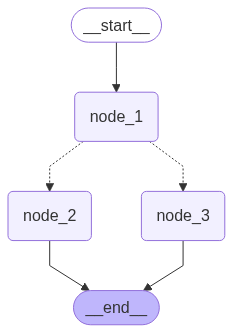

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Construindo o grafo
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Lógica do grafo
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compilação
graph = builder.compile()

# Visualização
display(Image(graph.get_graph().draw_mermaid_png()))

##### **Invocação**

O grafo compilado implementa um protocolo executável.

Isso fornece um modo padrão para executar os componentes do LangChain.

`invoke` é um dos métodos padrões do framework.

O dicionário de *input* `{"graph_state": "Olá, sou um participante da Oficina de LangGraph."}` define o valor inicial para o *state* do grafo.

Quando `invoke` é chamado, o grafo inicia a execução a partir do nó `START`.

Então o fluxo progride através dos nós definidos (`node_1`, `node_2`, `node_3`), em ordem.

O nó condicional irá direcionar do nó `1` para o nó `2` ou `3` usando uma regra de probabilidade de 50%.

Cada função de nó recebe o `state` atual e sobrescreve ele.

A execução continua ate chegar ao nó `END`.

In [16]:
graph.invoke({"graph_state": "Olá, sou um participante da Oficina de LangGraph."})

--- Nó 1 ---
--- Nó 2 ---


{'graph_state': 'Olá, sou um participante da Oficina de LangGraph. Eu estou feliz!'}

`invoke` executa todo o grafo de forma sícrona, esperando cada passo ser completo antes de ir para o próximo.

Isso retorna o *state* final do grafo após todos os nós serem executados.

Neste caso, o *state* retorna após o nó 3 ser completo.

### **Chain**

Construir uma *chain* simples combina 4 conceitos básicos:

- Uso de mensagens de chat no grafo;
- Uso de modelos de chat;
- Atribuir ferramentas à LLMs;
- Executar chamadas de ferramentas nos grafos.

##### **Messages**

[Modelos de chat](https://python.langchain.com/docs/integrations/chat/) podem usar `messages`, que capturam diferentes papeis em uma conversa.

LangChain suporta diversos tipos de menssagens, incluindo `HumanMessage`, `AIMessage`, `SystemMessage`, e `ToolMessage`.

Cada mensagem pode ser fornecida com:

- `content` - conteúdo da mensagem;
- `name` - nome de quem está criando a mensagem (opcional);
- `response_metadata`- um dicionário de metadados específico para cada modelo (opcional).

In [17]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content='Então você está pesquisando lugares para passar as férias?', name='Model')]
messages.extend([HumanMessage(content="Sim. Corretamente", name='Lucas')])
messages.extend([AIMessage(content='Ótimo, o que você gostaria de saber?', name='Model')])
messages.extend([HumanMessage(content='Eu quero saber quais os melhores bares de Pipa.', name='Lance')])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Então você está pesquisando lugares para passar as férias?
================================ Human Message =================================
Name: Lucas

Sim. Corretamente
================================== Ai Message ==================================
Name: Model

Ótimo, o que você gostaria de saber?
================================ Human Message =================================
Name: Lance

Eu quero saber quais os melhores bares de Pipa.


##### **Modelos de Chat**

Os modelos podem usar uma sequência de mensagens como *input* e executar papéis presentes nas mensagens.

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [19]:
result.pretty_print()

================================== Ai Message ==================================

Pipa tem uma vida noturna super agitada e bares para todos os gostos! Para te ajudar a escolher os "melhores", vou listar alguns que se destacam em diferentes categorias. Lembre-se que "melhor" é subjetivo, mas esses são consistentemente bem avaliados:

**Para Dançar e Curtir a Noite (Música ao Vivo e DJs):**

1.  **Calangos Bar:** Um clássico de Pipa! Famoso pelo forró pé de serra ao vivo, é o lugar perfeito para quem quer dançar e sentir a energia local. A pista fica cheia e a atmosfera é contagiante.
2.  **Tribus Bar:** Outro ponto de encontro tradicional, o Tribus costuma ter bandas de rock, reggae e MPB ao vivo. É um bar com uma vibe mais descontraída e ótima para quem gosta de música boa e um ambiente animado.
3.  **Área Restrita:** Se você busca algo mais eletrônico e para ir até mais tarde, o Área Restrita é uma ótima pedida. Com DJs e um ambiente mais de balada, é ideal para quem quer dançar sem 

##### **Tools**

Ferramentas são necessárias sempre que você quer que um modelo controle partes de código ou chamar APIs e funções externas.

Diversos LLMs oferecem suporte para chamdas de ferramentas.

A interface de chamada de ferramentas no LangChain é simples.

Você apenas precisa passar qualquer função Python para o `ChatModel.bind_tools()`.

In [21]:
def multiply(a:int, b:int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [22]:
tool_call = llm_with_tools.invoke([HumanMessage(content="Quanto é 2 multiplicado por 3", name="Lucas")])
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--99dba08c-7fbb-49ea-9e2b-446003c3a36c-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '6c4a9923-d37e-47b7-b42e-34a04949f907', 'type': 'tool_call'}], usage_metadata={'input_tokens': 71, 'output_tokens': 87, 'total_tokens': 158, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 69}})

##### **Utilizando mensagens como states**

Com esses fundamentos, agora já podemos utilizar `messages` no nosso grafo de states.

Vamos definir nossso state `MessageState` como um `TypedDict` com apenas uma chave: `messages`.

`messages` é apenas uma lista de `AnyMessages` (lista de mensagens).

In [24]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

##### **Reducers**

Agora temos um pequeno problema.

Enquanto o grafo é executado, nós queremos anexar nossas mensagens à nossa chave de state `messages`.

Mas cada nó irá sobresecrever o valor do state anterior.

[**Reducer functions**](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) resolvem isso.

Elas nos permitem especificar como a atualização do state é executada.

Caso nenhuma função de reducer é definida, é assumido que todos os updates da chave devem *sobrescrever* o valor anterior.

Já que queremos anexar mensagens, podemos usar o reducer pré-construído `add_messages`!


Isso garante que as atualizações de state enviadas para o grafo sejam anexadas em uma lista existente de mensagens.


Nós anotamos (via `Annotated`) nossa chave com uma função de reducer como metadata.

In [25]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Já que ter uma lista de mensagens como state é tão comum, LangGraph tem um `MessagesState` pré-construído!

`MessagesState` é definido:

* Com uma única chave `messages` pré-construída
* Que é uma lista de objetos `AnyMessage` e utiliza o reducer `add_messages`

In [26]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # Adicione qualquer chave necessária além de messages
    pass

O `MessagesState` e `State` funcionam de forma equivalente!

Para ir mais a fundo, nós podemos ver como o reducer `add_messages` funciona de forma isolada.

In [27]:
# State inicial
initial_messages = [AIMessage(content='Olá! Como posso te ajudar?', name='Model'),
                    HumanMessage(content="Estou procurando dicas de viagens.", name='Lucas')]

# Nova mensagem para adicionar
new_message = AIMessage(content='Claro, posso te ajudar com isso! Para onde em específico você quer ir?', name='Model')

# Teste
add_messages(initial_messages, new_message)

[AIMessage(content='Olá! Como posso te ajudar?', additional_kwargs={}, response_metadata={}, name='Model', id='387bbb02-402f-4046-829a-a775f190a6e1'),
 HumanMessage(content='Estou procurando dicas de viagens.', additional_kwargs={}, response_metadata={}, name='Lucas', id='7c61e0d3-304d-4d23-acd4-29f3cd7c2d62'),
 AIMessage(content='Claro, posso te ajudar com isso! Para onde em específico você quer ir?', additional_kwargs={}, response_metadata={}, name='Model', id='2b59ee9c-a6d9-4acf-8ec7-3b6ff796e5f9')]

##### **Nosso grafo**

Agora, vamos usar `MessagesState` com um grafo

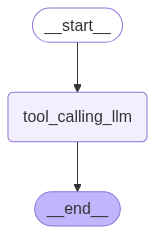

In [29]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# state
class MessagesState(MessagesState):
    pass

# nó
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

# construção do grafo
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# visualização
display(Image(graph.get_graph().draw_mermaid_png()))


Aqui, a LLM responde normalmente sem nenhuma chamada de ferramenta.

In [30]:
messages = graph.invoke({"messages": HumanMessage(content="Olá Gemini!")})
messages

{'messages': [HumanMessage(content='Olá Gemini!', additional_kwargs={}, response_metadata={}, id='f5994eec-7604-4265-8c82-c7cc663919c2'),
  AIMessage(content='Olá! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--5d7cc6ba-80b3-4969-9700-17fcc6f174b3-0', usage_metadata={'input_tokens': 66, 'output_tokens': 8, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}})]}

Aqui, ela percebe a solicitação e envia para o nó de ferramenta.

In [31]:
messages = graph.invoke({"messages": HumanMessage(content="Multiplique 2 e 3!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiplique 2 e 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (93e6342f-7dc4-4ca2-9fbd-d1e0adf6905e)
 Call ID: 93e6342f-7dc4-4ca2-9fbd-d1e0adf6905e
  Args:
    b: 3.0
    a: 2.0


### **Router**

##### **Objetivos**

Podemos pensar nisso como um "roteador", onde o modelo de chat roteia entre uma resposta direta ou uma chamada de ferramenta baseando-se na entrada do usuário.

Vamos estender nosso grafo para trabalhar com ambas outputs!

Para isso, nós podemos usar duas ideias:

1. Adicionar um nó que irá chamar nossa ferramenta.
2. Adicionar uma aresta condicional que irá olhar o output do modelo e direcionar para a nosso nó de ferramenta ou simplesmente finalizar caso nenhuma ferramenta for solicitada.

Nós usaremos o nó **pré-construído** `ToolNode` e simplesmente passar uma lista das nossas ferramentas para inicializá-lo.

Também usaremos a aresta condicional **pré-construída** `tools_condition`.

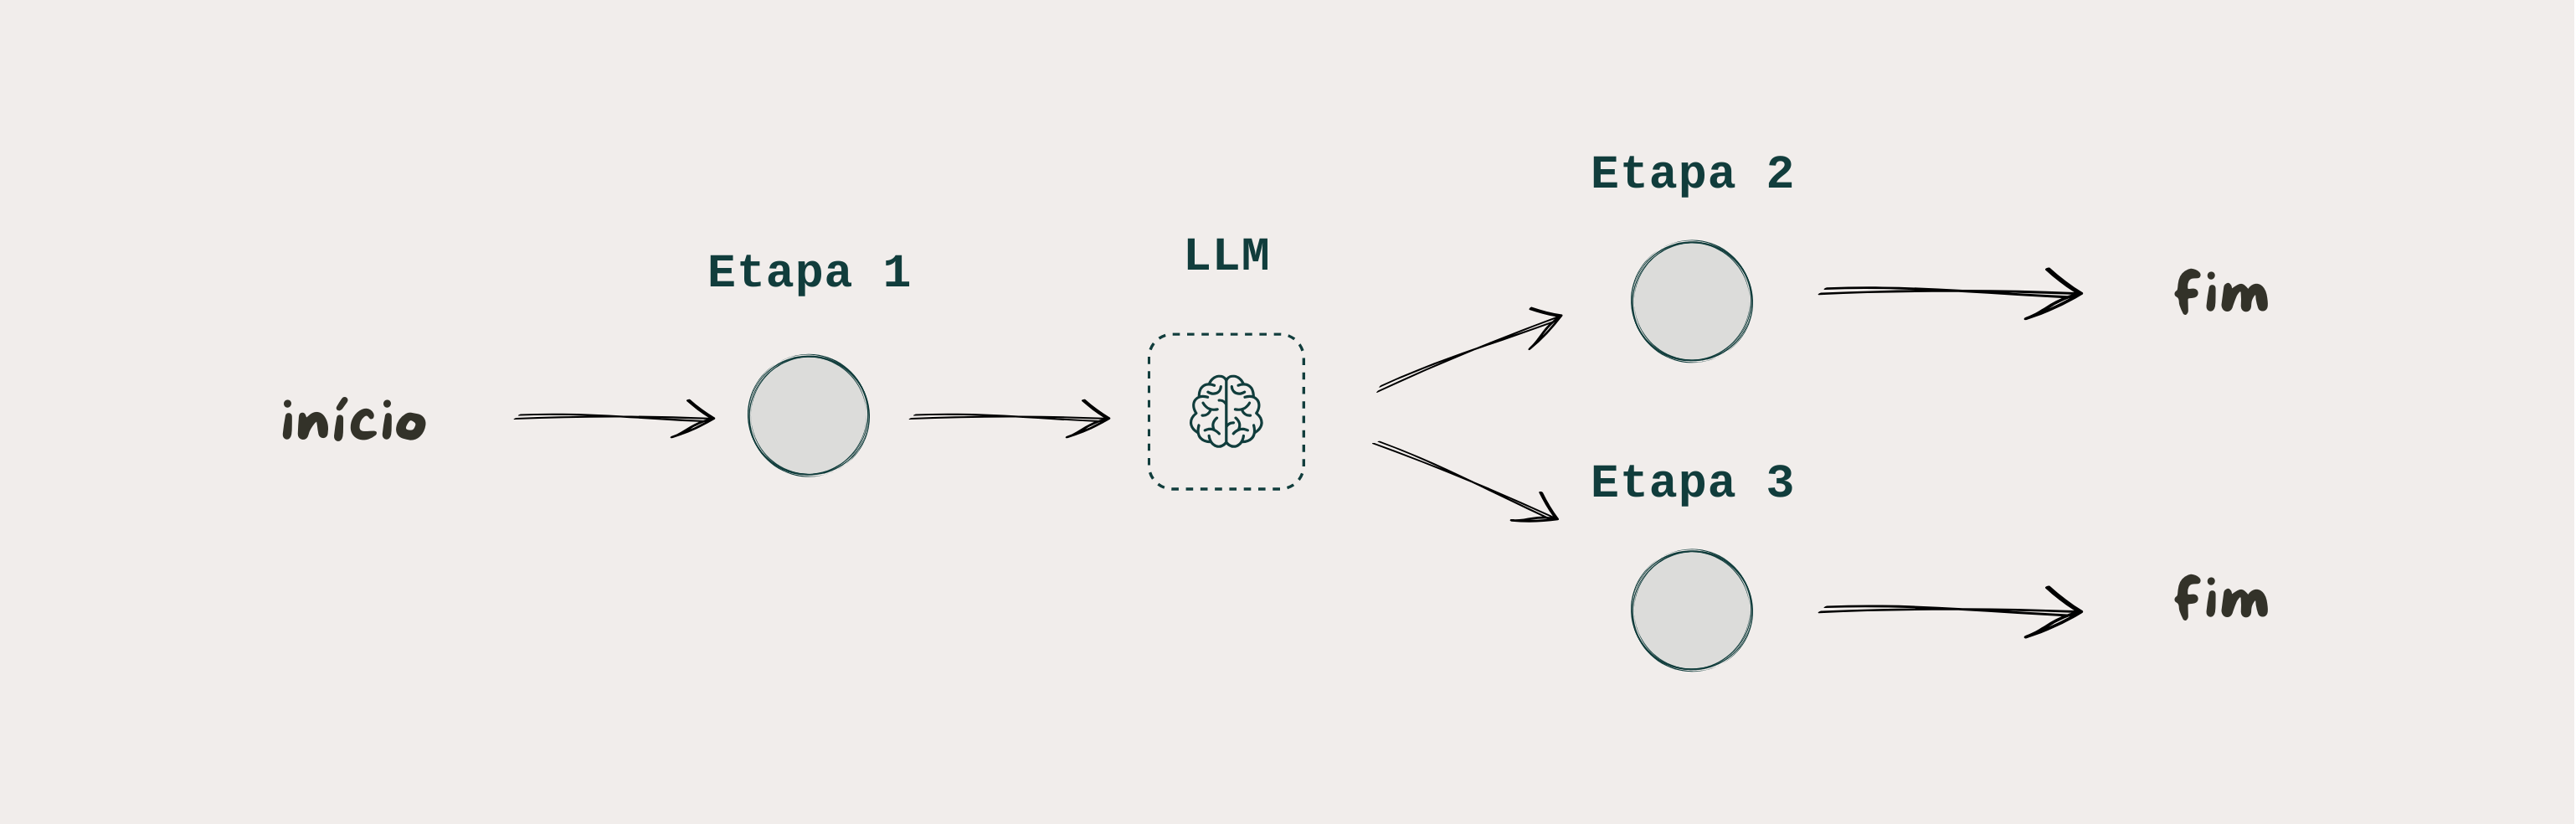

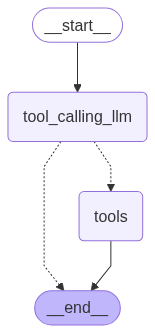

In [33]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Nó
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Construir o grafo
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # Se a ultima messanges (result) do assistente é uma cahamada de ferramenta -> tools_condition direciona para tools
    # Se a ultima mensagem (result) do assistente é não é uma chamada de ferramenta -> tools_condition direciona para o EN
    tools_condition,
)

builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
from langchain_core.messages import HumanMessage
from pprint import pprint

messages = [HumanMessage(content="Quanto é 3 vezes 4?")]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Quanto é 3 vezes 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (e1bb0195-30cd-48c7-a189-d6d259df4e61)
 Call ID: e1bb0195-30cd-48c7-a189-d6d259df4e61
  Args:
    b: 4.0
    a: 3.0
================================= Tool Message =================================
Name: multiply

12


Agora, podemos ver que o grafo executa a ferramenta.

Ele responde com uma `ToolMessage`.

### **Agente ReAct**

##### **Objetivo**

Agora, podemos estender esse grafo em arquitetura genérica de agentes.

No router anterior, nós invocamos o modelo e, caso ele escolhesse chamar uma ferramenta, retornaríamos uma `ToolMessage` para o usuário.

Mas, e se nós passarmos essa `ToolMessage` de volta para o modelo?

Nós podemos (1) chamar outra ferramenta ou (2) responder diretamente ao usuário.

Essa é a intuição por trás do *ReAct*, uma arquitetura geral de agentes,

* `act` - deixar o modelo chamar por ferramentas específicas
* `observe` - passar a resposta da ferramenta de volta ao modelo
* `reason` - deixar o modelo ponderar sobre o output da ferramenta e decidir o que fazer depois

Essa *arquitetura de uso geral* pode ser aplicada em diversas ferramentas.

In [35]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a * b


def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
llm_with_tools = llm.bind_tools(tools)

In [36]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Mensagem de sistema
sys_msg = SystemMessage(content='Você é um ajudante útil encarregado em fazer aritméticas em um conjunto de inputs.')

# Nó
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Assim como antes, nós usamos `MessagesState` and definimos um nó `Tool` com nossa lista de ferramentas.

O nó `Assistant` é apenas nosso modelo com ferramentas vinculadas.

Criamos um grafo com nós `Assistant` e `Tools`.

Adicionamos a aresta `tools_condition`, que direciona para `Tools` ou `END` dependendo se o `Assistant` chama uma ferramenta.

Agora, adicionaremos um novo passo:

Conectar o nó `Tools` *de volta* ao `Assistant`, criando um loop.

- Depois que o nó `Assistant` executa, `tools_condition` checa se a resposta do modelo é uma chamada de ferramenta
- Se for, o fluxo é direcionado para o nó `tools`
- O nó `Tools` se conecta de volta ao `Assistant`
- Esse loop continua enquanto o modelo decide chamar uma ferramenta
- Caso a resposta do modelo não seja uma chamada de ferramenta, o fluxo é direcionado ao `END`, finalizando o processo.

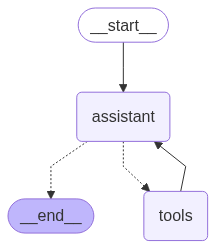

In [38]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Grafo
builder = StateGraph(MessagesState)

# Definição de nós
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Definição de arestas
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to end
    tools_condition,
)

builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Visualização
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
messages = [HumanMessage(content="Adicione 3 e 4. Multiplique a resposta por 2, então divida por 5.")]
messages = react_graph.invoke({"messages": messages})

In [40]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Adicione 3 e 4. Multiplique a resposta por 2, então divida por 5.
================================== Ai Message ==================================
Tool Calls:
  add (5e025395-2aca-4e85-8374-01c0d4a1bc99)
 Call ID: 5e025395-2aca-4e85-8374-01c0d4a1bc99
  Args:
    b: 4.0
    a: 3.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (10665717-672c-4b2b-99bd-a00f235c64fd)
 Call ID: 10665717-672c-4b2b-99bd-a00f235c64fd
  Args:
    b: 2.0
    a: 7.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (1b0f64e0-0ba8-4652-b375-a3f3f42f5399)
 Call ID: 1b0f64e0-0ba8-4652-b375-a3f3f42f5399
  Args:
    b: 5.0
    a: 14.0
====

#### **Assistente de Viagens**

Esse sistema de agentes irá no ajudar com estimativas de preços de viagens, recomendações de locais para visitar e bares/restaurantes para frequentar.

In [45]:
# Definir nós de agentes
def agente_de_voo(state: MessagesState):
    """Agente especializado em busca de vôos"""
    print("-- Agente de voo --")
    sys_msg = SystemMessage(content='Você é um especialista em reservas de vôos. Foque em achar e explorar APENAS opções de vôos, preços e itinerários. Recomende os vôos mais próximos, também escolha o melhor aeroporto. Responda apenas sobre vôos.')
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


def agente_de_hospedagem(state: MessagesState):
    """Agente especializado em busca de hospedagem"""
    print("-- Agente de Hospedagem --")
    sys_msg = SystemMessage(content='Você é um especialista em hotéis. Foque em achar e explorar APENAS opções de hospedagem, preços e acomodações. Dê exemplos com preços e localidades variadas. Responda apenas sobre hospedagem.')
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


def agente_de_restaurantes(state: MessagesState):
    """Agente especializado em recomendação de restaurantes"""
    print("-- Agente de Restaurantes --")
    sys_msg = SystemMessage(content='Você é um especialista em restaurantes. Foque em achar e explorar APENAS opções de restaurantes, preços e cozinhas. Responda apenas sobre restaurantes.')
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


def agente_de_atracoes(state: MessagesState):
    """Agente especializado em atrações turísticas"""
    print("-- Agente de Atrações --")
    sys_msg = SystemMessage(content='Você é um especialista em atrações turísticas. Foque em achar e explorar APENAS opções de atrações, atividades e experiências. Responda apenas sobre atividades e pontos turísticos.')
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


def agente_coordenador(state: MessagesState):
    """Agente coordenador que decide qual agente usar"""
    sys_msg = SystemMessage(content="""Você é um coordenador de viagens. Analise o pedido do usuário e decida qual especialista solicitar pesquisa:
    - Para buscas referentes a vôos, responda com "DIRECIONAR_PARA: VOO"
    - Para buscas referentes a hospedagem, responda com "DIRECIONAR_PARA: HOSPEDAGEM"
    - Para buscas referentes a restaurantes, responda com "DIRECIONAR_PARA: RESTAURANTE
    - Para buscas referentes a atrações, responda com "DIRECIONAR_PARA: ATRACAO"
    - Se uma requisição precisar de mais de um espcialista, liste eles em ordem: "DIRECIONAR_PARA: [ESPECIALISTA_1] [ESPECIALISTA_2] ...s [ESPECIALISTA_N]".
    Você também deve informar o que o usuário está solicitando.
    - Caso a pergunta não esteja relacionada a viagens, retorne END.
    """)
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


def agente_agregador(state: MessagesState):
    """Agente que agrega as respostas de todos os agentes"""
    responses = [msg.content for msg in state["messages"]]
    prompt = [
        SystemMessage(content="Você deve agregar e resumir todas as respostas que você receber dos agentes em um output."),
        HumanMessage(content=f"Agora, agregue as seguintes respostas encontradas: {responses}")
    ]
    result = llm.invoke(prompt)
    return {"messages": result}


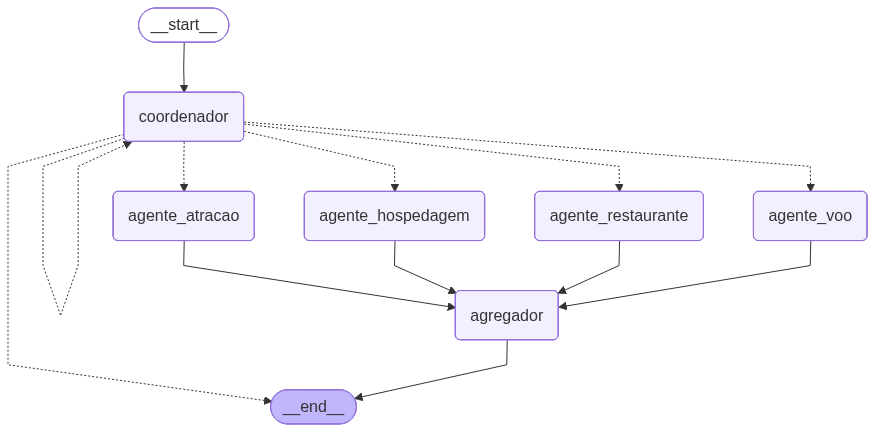

In [47]:
# Construindo o grafo
builder = StateGraph(MessagesState)

# Adicionando nós
builder.add_node("coordenador", agente_coordenador)
builder.add_node("agente_voo", agente_de_voo)
builder.add_node("agente_hospedagem", agente_de_hospedagem)
builder.add_node("agente_restaurante", agente_de_restaurantes)
builder.add_node("agente_atracao", agente_de_atracoes)
builder.add_node("agregador", agente_agregador)

# Adicionando arestas
builder.add_edge(START, "coordenador")

# Adicionando arestas condicionais baseando-se na escolha do coordenador
def route_to_agent(state):
    """Direciona para o agente apropriado com base na escolha do coordenador"""
    last_message = state["messages"][-1]
    agents_list = []
    if not isinstance(last_message, AIMessage):
        agents_list.append("coordenador")


    content = last_message.content
    if "VOO" in content:
        agents_list.append("agente_voo")
    if "HOSPEDAGEM" in content:
         agents_list.append("agente_hospedagem")
    if "RESTAURANTE" in content:
        agents_list.append("agente_restaurante")
    if "ATRACAO" in content:
        agents_list.append("agente_atracao")
    else:
        agents_list.append(END)
    return agents_list


builder.add_conditional_edges(
    "coordenador",
    route_to_agent,
    {
        "agente_voo": "agente_voo",
        "agente_hospedagem": "agente_hospedagem",
        "agente_restaurante": "agente_restaurante",
        "agente_atracao": "agente_atracao",
        "coordenador": "coordenador",
        END:END
    }
)

builder.add_edge("agente_voo", "agregador")
builder.add_edge("agente_hospedagem", "agregador")
builder.add_edge("agente_restaurante", "agregador")
builder.add_edge("agente_atracao", "agregador")

builder.add_edge("agregador", END)

# Compilar grafo
grafo_viagem = builder.compile()

display(Image(grafo_viagem.get_graph(xray=True).draw_mermaid_png()))

In [28]:
messages = [HumanMessage(content="Me diga a receita de torta de chocolate")]
result = grafo_viagem.invoke({"messages": messages})

In [29]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Me diga a receita de torta de chocolate
================================== Ai Message ==================================

END


In [33]:
messages = [HumanMessage(content="Quero ir para manaus de campina grande, me recomende voos e hoteis")]
result = grafo_viagem.invoke({"messages": messages})

-- Agente de voo ---- Agente de Hospedagem --



In [34]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Quero ir para manaus de campina grande, me recomende voos e hoteis
================================== Ai Message ==================================

DIRECIONAR_PARA: VOO HOSPEDAGEM. O usuário quer pesquisar voos de Campina Grande para Manaus e recomendações de hotéis em Manaus.
================================== Ai Message ==================================



Ok, vamos focar nas opções de hospedagem em Manaus. Para te dar as melhores recomendações, preciso saber um pouco mais sobre o que você procura:

*   **Qual o seu orçamento?** Hotéis de luxo, opções mais econômicas, hostels?
*   **Que tipo de experiência você busca?** Perto de atrações turísticas, em meio à natureza, com piscina e outras comodidades?
*   **Quais são suas prioridades?** Café da manhã incluso, Wi-Fi gratuito, estacionamento, acessibilidade?

Enquanto isso, posso te dar alguns exemplos de hotéis em Manaus com diferentes faixas de preço

In [32]:
messages = [HumanMessage(content="Quais as melhores atrações de Campina Grande - PB?")]
result = grafo_viagem.invoke({"messages": messages})

for m in result['messages']:
    m.pretty_print()

-- Agente de Atrações --
================================ Human Message =================================

Quais as melhores atrações de Campina Grande - PB?
================================== Ai Message ==================================

DIRECIONAR_PARA: ATRACAO
O usuário está solicitando informações sobre as melhores atrações em Campina Grande, Paraíba.
================================== Ai Message ==================================



Campina Grande oferece uma variedade de atrações turísticas interessantes. Aqui estão algumas das melhores:

*   **O Maior São João do Mundo:** Se você visitar Campina Grande em junho, não pode perder o Maior São João do Mundo. É uma festa junina gigante com shows, comidas típicas, apresentações culturais e muita animação.

*   **Parque do Povo:** O coração do Maior São João do Mundo, o Parque do Povo é um espaço amplo que abriga diversos palcos, barracas de comida e bebida, e áreas de lazer. Mesmo fora da época junina, o parque é um local agradável p